## Install the package dependencies before running this notebook

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

s = """
    number of trajectories in each city 
    # austin --  train: 43041 test: 6325
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    """
print(s)



    number of trajectories in each city 
    # austin --  train: 43041 test: 6325
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    


## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# Returns entire dataset for a city. Training input and label output, or just test input.
def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = os.path.join(ROOT_PATH, split, f"{city}_inputs")
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs) # All input trajectories
    outputs = None # Labels when training, empty if testing
    
    if split=="train":
        f_out = os.path.join(ROOT_PATH, split, f"{city}_outputs")
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

"""Dataset class for Argoverse"""
class ArgoverseDataset(Dataset):
    def __init__(self, city:str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx]) # Each data is a tuple of (input trajectory, output trajectory)
        if self.transform:
            data = self.transform(data)
        return data

In [4]:
inputs, outputs = get_city_trajectories()
inputs.shape

(11993, 50, 2)

In [5]:
full_seq = np.concatenate([inputs, outputs], axis=1)

full_seq.shape

(11993, 110, 2)

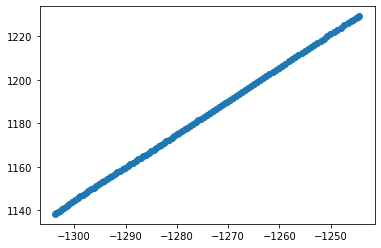

In [6]:
import matplotlib.pyplot as plt
# Plot for confirmation
plt.scatter(full_seq[0, :, 0], full_seq[0, :, 1])

In [7]:
def get_city_trajectory_OBO(city="palo-alto", split="train", normalized=False):
    # Get inputs like usual
    inputs, outputs = get_city_trajectories(city, split, normalized)
    new_inputs, new_outputs = [], []
    num_outs = 60
    seq_len = 50
    # Concatenate outputs horizontally
    full_seq = np.concatenate([inputs, outputs], axis=1)
    first_seq = True
    with torch.no_grad():
        for sequence in full_seq:
            # Create 60 new inputs from one sequence
            for i in range(num_outs):
                new_seq_in = sequence[i:i+seq_len].flatten().reshape(1, 100)
                #print(new_seq_in.shape)
                new_seq_out = sequence[i+seq_len].reshape(1,2)
                #print(new_seq_out)
                new_inputs.append(new_seq_in)
                new_outputs.append(new_seq_out)
            
    return torch.tensor(np.array(new_inputs)), torch.tensor(np.array(new_outputs))

"""Dataset class for Argoverse"""
class ArgoverseDatasetOneByOne(Dataset):
    """Argoverse dataset but every example has 60 different examples."""
    def __init__(self, city:str, split:str, transform=None):
        super(ArgoverseDatasetOneByOne, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_city_trajectory_OBO(city=city, split=split, normalized=False)
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx]) # Each data is a tuple of (input trajectory, output trajectory)
        if self.transform:
            data = self.transform(data)
        return data

In [8]:
new_in, new_out = get_city_trajectory_OBO(city='palo-alto')

In [9]:
new_in.shape

torch.Size([719580, 1, 100])

In [10]:
new_out.shape

torch.Size([719580, 1, 2])

## Checking loss graphs 

In [11]:
"""
# !pwd
# str = "why is pickle broken?"
# with open("pickle", "wb") as f:
#     print("dumping")
#     pickle.dump(str,f)
#     f.close()
#     print("dumped?")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker    
with open("mlp1", "rb") as g:
    print("loading mlp1")
    data_dict = pickle.load(g)
    for city_number,city in enumerate(cities):
        all_losses1 = data_dict[f"train_losses_{city}"]
        all_losses2 = data_dict[f"validation_losses_{city}"]  
#         data_dict[""]
        plt.figure()
        ax = plt.gca()
        ax.set_ylim([0,500000])
        plt.title(city)
        plt.plot(all_losses1,label="avg. train loss")
        plt.plot(all_losses2,label="avg. validation loss")
        leg = plt.legend(loc='upper center')
        plt.show()
#     print(f"newstr = {newstr}")
#     g.close()
print(type(data_dict))
""";

## Inference on test set

## Loop over all cities

Starting training for austin.
train_samples_per_epoch = 2400000
validation_samples_per_epoch = 300000
(train) epoch 1,      avg. train loss     : 399296.76637333335
(validation) epoch 1, avg. validation loss: 8915.793066666667
epoch took 36.96313238143921 seconds
(train) epoch 2,      avg. train loss     : 7842.50461
(validation) epoch 2, avg. validation loss: 2560.1444266666667
epoch took 33.7335364818573 seconds
(train) epoch 3,      avg. train loss     : 1288.0267141666666
(validation) epoch 3, avg. validation loss: 550.1090533333333
epoch took 33.04533934593201 seconds
(train) epoch 4,      avg. train loss     : 514.6419325
(validation) epoch 4, avg. validation loss: 411.90088
epoch took 34.12329959869385 seconds
(train) epoch 5,      avg. train loss     : 441.18906458333333
(validation) epoch 5, avg. validation loss: 380.76148
epoch took 33.566813945770264 seconds
(train) epoch 6,      avg. train loss     : 422.9285966666667
(validation) epoch 6, avg. validation loss: 371.59186666

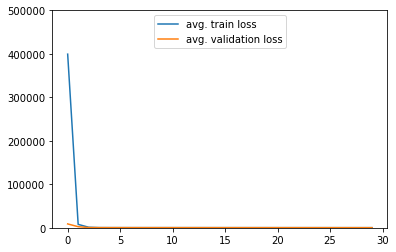



Starting training for miami.
train_samples_per_epoch = 3000000
validation_samples_per_epoch = 400000
(train) epoch 1,      avg. train loss     : 1662525.302784
(validation) epoch 1, avg. validation loss: 86093.88288
epoch took 44.017366886138916 seconds
(train) epoch 2,      avg. train loss     : 24998.448245333333
(validation) epoch 2, avg. validation loss: 3279.44504
epoch took 42.66583609580994 seconds
(train) epoch 3,      avg. train loss     : 1754.008768
(validation) epoch 3, avg. validation loss: 735.727635
epoch took 45.7443482875824 seconds
(train) epoch 4,      avg. train loss     : 637.165196
(validation) epoch 4, avg. validation loss: 443.105485
epoch took 45.52912926673889 seconds
(train) epoch 5,      avg. train loss     : 492.24784
(validation) epoch 5, avg. validation loss: 381.525195
epoch took 45.91026306152344 seconds
(train) epoch 6,      avg. train loss     : 442.893696
(validation) epoch 6, avg. validation loss: 353.299875
epoch took 43.61928653717041 seconds
(t

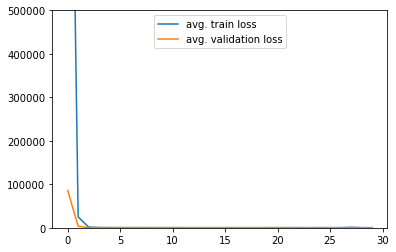



Starting training for pittsburgh.
train_samples_per_epoch = 2400000
validation_samples_per_epoch = 300000
(train) epoch 1,      avg. train loss     : 2345622.98944
(validation) epoch 1, avg. validation loss: 147029.85216
epoch took 38.1077516078949 seconds
(train) epoch 2,      avg. train loss     : 81153.47978666666
(validation) epoch 2, avg. validation loss: 7657.898666666667
epoch took 34.82167935371399 seconds
(train) epoch 3,      avg. train loss     : 5795.19064
(validation) epoch 3, avg. validation loss: 1272.4560266666667
epoch took 34.811970233917236 seconds
(train) epoch 4,      avg. train loss     : 893.0446366666666
(validation) epoch 4, avg. validation loss: 483.985
epoch took 35.75724387168884 seconds
(train) epoch 5,      avg. train loss     : 500.56862666666666
(validation) epoch 5, avg. validation loss: 409.91936
epoch took 34.98202586174011 seconds
(train) epoch 6,      avg. train loss     : 439.0843825
(validation) epoch 6, avg. validation loss: 373.86141333333336


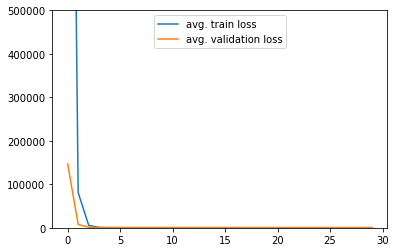



Starting training for dearborn.
train_samples_per_epoch = 1400000
validation_samples_per_epoch = 200000
(train) epoch 1,      avg. train loss     : 15238316.108068572
(validation) epoch 1, avg. validation loss: 2780352.1024
epoch took 18.04275369644165 seconds
(train) epoch 2,      avg. train loss     : 1298743.0405485714
(validation) epoch 2, avg. validation loss: 148186.94656
epoch took 17.192814350128174 seconds
(train) epoch 3,      avg. train loss     : 208959.62882285714
(validation) epoch 3, avg. validation loss: 6298.8264
epoch took 17.77970027923584 seconds
(train) epoch 4,      avg. train loss     : 27139.125725714286
(validation) epoch 4, avg. validation loss: 2799.36312
epoch took 17.618773460388184 seconds
(train) epoch 5,      avg. train loss     : 6249.6257642857145
(validation) epoch 5, avg. validation loss: 1501.41772
epoch took 17.92022132873535 seconds
(train) epoch 6,      avg. train loss     : 2057.46681
(validation) epoch 6, avg. validation loss: 1085.1908
epoch

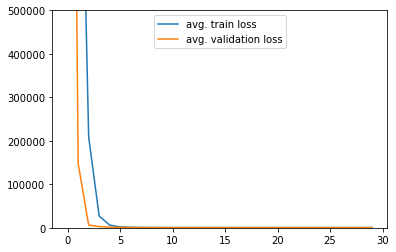



Starting training for washington-dc.
train_samples_per_epoch = 1400000
validation_samples_per_epoch = 200000
(train) epoch 1,      avg. train loss     : 4119843.24608
(validation) epoch 1, avg. validation loss: 377253.95968
epoch took 19.52562928199768 seconds
(train) epoch 2,      avg. train loss     : 368575.4368457143
(validation) epoch 2, avg. validation loss: 62244.49024
epoch took 19.83663845062256 seconds
(train) epoch 3,      avg. train loss     : 41410.65856
(validation) epoch 3, avg. validation loss: 27171.98976
epoch took 20.086342811584473 seconds
(train) epoch 4,      avg. train loss     : 10530.976365714285
(validation) epoch 4, avg. validation loss: 5298.37472
epoch took 20.523156881332397 seconds
(train) epoch 5,      avg. train loss     : 2712.9194228571428
(validation) epoch 5, avg. validation loss: 799.12228
epoch took 19.413543224334717 seconds
(train) epoch 6,      avg. train loss     : 842.4967285714285
(validation) epoch 6, avg. validation loss: 460.37493
epoch

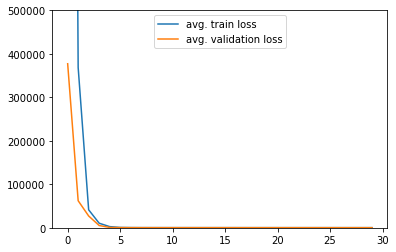



Starting training for palo-alto.
train_samples_per_epoch = 700000
validation_samples_per_epoch = 100000
(train) epoch 1,      avg. train loss     : 1333699.6922514285
(validation) epoch 1, avg. validation loss: 252622.45888
epoch took 8.206726551055908 seconds
(train) epoch 2,      avg. train loss     : 194155.45929142856
(validation) epoch 2, avg. validation loss: 56816.2304
epoch took 8.236975193023682 seconds
(train) epoch 3,      avg. train loss     : 43112.49225142857
(validation) epoch 3, avg. validation loss: 34407.10144
epoch took 8.263681888580322 seconds
(train) epoch 4,      avg. train loss     : 28101.421348571428
(validation) epoch 4, avg. validation loss: 11605.86496
epoch took 8.348739624023438 seconds
(train) epoch 5,      avg. train loss     : 10418.31104
(validation) epoch 5, avg. validation loss: 7913.22752
epoch took 8.900589227676392 seconds
(train) epoch 6,      avg. train loss     : 5839.558377142857
(validation) epoch 6, avg. validation loss: 2957.78496
epoch 

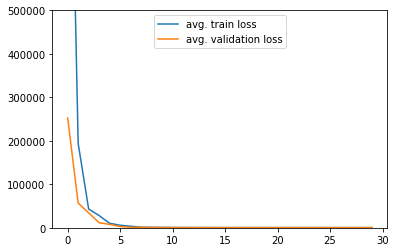



dumping
dumped?


In [12]:
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data_dict = {}

# Set hyperparameters
batch_size = 10000
lr = 0.001
num_epochs = 30
data_dict["batch_size"] = batch_size
data_dict["lr"] = lr
data_dict["num_epochs"] = num_epochs
device = torch.device('cuda')



# Train one model per city
models = [ None for city in cities ]
for city_number,city in enumerate(cities):
    print(f"Starting training for {city}.")
    # Prepare Dataset and Dataloader
    full_dataset  = ArgoverseDatasetOneByOne(city = city, split = 'train')
    train_set_length = int(len(full_dataset) * .9)
    valid_set_length = len(full_dataset)-train_set_length
    train_set, validation_set = torch.utils.data.random_split(full_dataset, [train_set_length, valid_set_length])
    train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True,pin_memory=True)
    validation_loader = DataLoader(validation_set, batch_size=batch_size)
    
    train_samples_per_epoch = len(train_loader) * batch_size # Number of batches times batch size
    validation_samples_per_epoch = len(validation_loader) * batch_size
    print(f"train_samples_per_epoch = {train_samples_per_epoch}")
    print(f"validation_samples_per_epoch = {validation_samples_per_epoch}")
    
    # Create model/optim/loss
    model = nn.Sequential(nn.Flatten(1,2),
                    nn.Linear(100, 512),
                    nn.ReLU(),
                    nn.Linear(512,50),
                    nn.ReLU(),
                    nn.Linear(50,2),
                     nn.Unflatten(1,(1,2)))
    model.cuda()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    loss_func = nn.MSELoss(reduction='sum')
    
    # Train model
    all_losses1 = []
    all_losses2 = []
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        # Train set
        model.train()
        train_loss = 0
        train_loss_alt = 0
        for i_batch, sample_batch in enumerate(train_loader):
            # Get input and output labels
            inp, out = sample_batch 
            inp = inp.float()
            out = out.float()      
            #print(inp.shape)
            #print(out.shape)
            inp, out = inp.to(device), out.to(device)
            # Forward pass
            out_hats = model(inp)
            #print(out_hats.shape)
            l = loss_func(out_hats, out)     
            # Gradient descent
            opt.zero_grad()
            l.backward()
            opt.step()        
            train_loss += l.item()
        all_losses1.append(train_loss / train_samples_per_epoch)  # Loss per training sample

        # Validation set
        model.eval()
        validation_loss = 0
        validation_loss_alt = 0
        for i_batch, sample_batch in enumerate(validation_loader):
            inp, out = sample_batch
            inp = inp.float()
            out = out.float()
            inp, out = inp.to(device), out.to(device)
            # Forward pass
            l = loss_func(model(inp), out)
            validation_loss += l.item()
        all_losses2.append(validation_loss / validation_samples_per_epoch) # Loss per validation sample

        # Print training progress
        print(f'(train) epoch {epoch + 1},      avg. train loss     : {train_loss / train_samples_per_epoch}')
        print(f'(validation) epoch {epoch + 1}, avg. validation loss: {validation_loss / validation_samples_per_epoch}')
        print(f'epoch took {time.time() - epoch_start_time} seconds')
        
    end_time = time.time()
    print(f"Entire training of {city}'s model took {end_time-start_time} seconds.")    
    models[city_number] = model
    data_dict[f"model_{city}"] = (model, model.state_dict())
    data_dict[f"train_losses_{city}"]  = all_losses1
    data_dict[f"validation_losses_{city}"]  = all_losses2

    # Graph training progress, should be per trajectory loss
    plt.figure()
    ax = plt.gca()
    ax.set_ylim([0,500000])
    plt.plot(all_losses1,label="avg. train loss")
    plt.plot(all_losses2,label="avg. validation loss")
    leg = plt.legend(loc='upper center')
    plt.show()    
    print()
    print()
data_dict["models"] = models    
# data_dir = os.path.join("/home/mhsiu/argo_kaggle/checkpoints/mlp1")
# print(data_dir)
with open("mlp1", "wb") as f:
    print("dumping")
    pickle.dump(data_dict,f)
    f.close()
    print("dumped?")
    
# with open("mlp1", "rb") as f:
#     print("loading")
#     loaded = pickle.load(f)
#     newstr = loaded["num_epochs"]
#     print(f"loaded = {newstr}")
#     f.close()
# #     print("dumped?")    

## Inference on test sets

In [58]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([100000, 1, 100])


In [89]:
inp = torch.tensor(
        inp.reshape([inp.shape[0], 1, -1]),
        device=device).float()

In [157]:
def predict(model, first_50):
    # Make sure model is in eval mode
    inputs = torch.tensor(
        first_50.reshape([first_50.shape[0], 1, -1]),
        device=device).float()
    outputs = []
    #print(inputs.shape)
    first_iter = True
    for _ in range(60):
        new_out = model(inputs)
        #print('iter')
        #print(new_out.shape)
        if first_iter:
            outputs = new_out
            first_iter = False
        else:
            outputs = torch.cat([outputs, new_out], 1)
        # Create new inputs
        #print(inputs[:, :, 2:].shape)
        inputs = torch.cat([inputs[:, :, 2:], new_out], 2)
        #print(outputs.shape)
    # Flatten x and y
    return outputs.flatten(1)

In [152]:
inp, out = get_city_trajectories(city='palo-alto', split='test')

In [153]:
model = data_dict['model_palo-alto'][0]

In [158]:
predict(model, inp).shape

torch.Size([1686, 120])

'[,1,,, ,2,,, ,3,]'

In [165]:
# Inference for every city's test inputs
format_str = "ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119"
with open('predictions.txt', 'w') as f:
    print(format_str,end='',file=f)
    for city_number,city in enumerate(cities):
        print(f"Starting testing for {city}.")

        # Prepare inputs
        test_inputs, _ = get_city_trajectories(city=city, split='test', normalized=False)
        print(f"test_inputs.shape = {test_inputs.shape}")
        num_scenes = test_inputs.shape[0]

        # Setup the model
        model, model_state_dict = data_dict[f"model_{city}"]
        model.cuda()
        model.eval()

        # Pass all inputs through model
        output_scenes = predict(model, test_inputs)
        
        
        for i,output_scene in enumerate(output_scenes):
            output_str = f'{i}_{city}'
            for num in output_scene:
                output_str += f',{num}'
            
            #for j,coord_pair in enumerate(output_scene):
            #    x,y = coord_pair
            #    output_str += f",{x},{y}"
            # Print to file
            print(output_str,end='\n',file=f)
#             break
#         break
        
    
    
    # Process model outputs

Starting testing for austin.
test_inputs.shape = (6325, 50, 2)
Starting testing for miami.
test_inputs.shape = (7971, 50, 2)
Starting testing for pittsburgh.
test_inputs.shape = (6361, 50, 2)
Starting testing for dearborn.
test_inputs.shape = (3671, 50, 2)
Starting testing for washington-dc.
test_inputs.shape = (3829, 50, 2)
Starting testing for palo-alto.
test_inputs.shape = (1686, 50, 2)


## Create a DataLoader class for training

In [ ]:
batch_sz = 4  # batch size 
fullcity_loader = DataLoader(city_dataset,batch_size=batch_sz)
print(f"{split.upper()} dataloader using batches of {batch_sz} is ready for city {city.upper()}.")

## Sample a batch of data and visualize 

In [ ]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    print(f"    Shape is (batch, trajectory_length, coord_dim)")
    print(f"    inp shape = {inp.shape}")
    print(f"    out shape = {out.shape}")
    batch_sz = inp.size(0)
    agent_sz = inp.size(1) # Input trajectory length?
    print(f"    batch_sz = {batch_sz}")
    print(f"    agent_sz = {agent_sz}")
    
    fig, axs = plt.subplots(2,batch_sz, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()   
    print("\nEach column is one (input,output) pair")
    axs[0][0].set_ylabel("First row")
    for i in range(batch_sz):
        # first two feature dimensions are (x,y) positions
        axs[0][i].scatter(inp[i,:,0], inp[i,:,1], c='lightskyblue')
        axs[1][i].scatter(out[i,:,0], out[i,:,1], c='lightcoral')
        # Show position at first time step
        axs[0][i].scatter(inp[i,0,0], inp[i,0,1], c='g')
        axs[1][i].scatter(out[i,0,0], out[i,0,1], c='g')        

        
for ith_batch, sample_batch in enumerate(fullcity_loader):
    print(f"Loaded batch #{ith_batch}")
    inp, out = sample_batch #
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

## Training Loop

In [ ]:

# loss = nn.MSELoss()
# input = torch.arange(12,dtype=torch.float32).reshape((3,4))
# print(input)
# target = input + 2
# print(target)
# output = loss(input,target)
# print(output)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")
!nvidia-smi -L

In [ ]:

# '''
# Define model
mlp = nn.Sequential(nn.Flatten(1,2),
                    nn.Linear(100, 256),
                    nn.ReLU(),
                    nn.Linear(256,256),
                    nn.ReLU(),
                    nn.Linear(256,120),
                    nn.Unflatten(1,(60,2)))

mlp.cuda()

# Hyperparameters
lr = 0.0001
num_epochs = 100
opt = torch.optim.Adam(mlp.parameters(),lr=lr)
# opt = torch.optim.SGD(mlp.parameters(),lr=lr)
loss_func = nn.MSELoss(reduction='sum')

# Train/val split
city = 'palo-alto' 
split = 'train'
full_dataset  = ArgoverseDataset(city = city, split = split)
train_set, validation_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*5/6), len(full_dataset)-int(len(full_dataset)*5/6)])

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True,drop_last=True,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,drop_last=True)
train_samples_per_epoch = len(train_loader) * batch_size # Number of batches times batch size
validation_samples_per_epoch = len(validation_loader) * batch_size
print(f"train_samples_per_epoch = {train_samples_per_epoch}")
print(f"validation_samples_per_epoch = {validation_samples_per_epoch}")

all_losses1 = []
all_losses2 = []
# '''

# lr = 0.0001
# num_epochs = 100
# opt = torch.optim.Adam(mlp.parameters(),lr=lr)


import time
# from math import sqrt
from tqdm import tqdm
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    # Epoch for train set
    mlp.train()
    train_loss = 0
    train_loss_alt = 0
    for i_batch, sample_batch in enumerate(tqdm(train_loader)):
        inp, out = sample_batch # Get input and output labels
        inp = inp.float()
        out = out.float()      
        inp, out = inp.cuda(), out.cuda()
#         print(f"inp.shape = {inp.shape}")
#         break
#         print(f"out shape = {out.shape}")
        
        # Forward pass
        out_hats = mlp(inp)
#         print(out_hats.shape)
        l_alt = ((mlp(inp) - out) ** 2).sum()
        l = loss_func(out_hats, out)     
        # Gradient descent
        opt.zero_grad()
        l.backward()
        opt.step()        
        train_loss += l.item()
        train_loss_alt += l_alt.item()
    all_losses1.append(train_loss / train_samples_per_epoch)  # Loss per training sample
        
    # Epoch for validation set
    mlp.eval()
    validation_loss = 0
    validation_loss_alt = 0
    for i_batch, sample_batch in enumerate(tqdm(validation_loader)):
        inp, out = sample_batch
        inp = inp.float()
        out = out.float()
        inp, out = inp.cuda(), out.cuda()
        # Forward pass
        l_alt = ((mlp(inp) - out) ** 2).sum()
        l = loss_func(mlp(inp), out)
        validation_loss += l.item()
        validation_loss_alt += l_alt.item()
    all_losses2.append(validation_loss / validation_samples_per_epoch) # Loss per validation sample
    
    # Print training progress
    print(f'(train) epoch {epoch + 1},      avg. train loss     : {train_loss / train_samples_per_epoch}')
    print(f'(validation) epoch {epoch + 1}, avg. validation loss: {validation_loss / validation_samples_per_epoch}')
    print(f"Epoch took {time.time()-epoch_start} seconds.\n")
    
end_time = time.time()
print(f"Entire training of {num_epochs} epochs took {end_time-start_time} seconds.")

In [ ]:
# 400 epochs at lr=0.00001 [done]

# ~100 epochs at lr=0.0001

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Should be per trajectory loss
plt.figure()
ax = plt.gca()
ax.set_ylim([0,500000])
plt.plot(all_losses1,label="avg. train loss")

# plt.plot(all_losses2,label="avg. validation loss")
leg = plt.legend(loc='upper center')
plt.show()

In [ ]:
# Inference on test

split = 'test'
counter = 0
currCity = 0
test_input, test_output = get_all_trajectories(split="test", normalized=False)
#We can't use a dataset or a dataloader because they don't work for the test set (something to do with the fact that the test set doesn't have outputs)

with open('predictions.txt', 'w') as f:
    print("hello",file=f, flush=True)
    for i_batch, curr_input in enumerate(test_input):
        #curr_input is a numpy array, so first we need to turn it into a tensor, then add an extra dimension around it, then make it a float tensor instead of a double tensor
        predict = mlps[currCity](torch.from_numpy(curr_input).unsqueeze(0).float())

        print("" + str(counter) + "_" + str(cities[currCity]),end='',file=f)
        for coor in predict[0]:
            print("," + str(coor[0].item()) + "," + str(coor[1].item()),end='',file=f)
        print(file=f, flush=True)
        counter = counter+1
        if counter >= test_lengths[currCity]:
            counter = 0
            currCity = currCity+1

    f.close()